# Classification of Pulsar Stars From the HTRU2 Data Set

In [1]:
set.seed(1)

install.packages("themis")
library(themis)
library(tidyverse) 
library(repr) 
library(tidymodels) 
library(ggplot2)
library(GGally)
library(cowplot)
library(caret)
library(yardstick)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: recipes

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed()
✖ dplyr::lag()     masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials   

## 1) Introduction

In this report, we will be creating a classifier using the HTRU2(High Time Resolution Universe) dataset to figure out if a set of signals is coming from a pulsar star or not. The HTRU2 dataset classifies radio signal profiles as those from pulsar stars or from non-pulsars/noise. Pulsars are a type of rare neutron star that are extremely dense and spins rapidly while emitting lots of light and radiation [1]. Pulsars are formed when a massive star which is 8-25 times the mass of the Sun explodes in a supernova event, leaving us with the inner part of the star crumbled together due to the force of gravity [2]. The pulsars are detected through periodic radio signals measured from Earth and have slightly different emission patterns depending on their rotation [3]. However, some of the detected periodic radio signals are the results of RFI (radio frequency interference) or noise, making it more challenging to recognize a pulsar. Therefore in building our classifier, we have decided to use the following variables as predictors*: 

- mean of the integrated profile
- excess kurtosis of the integrated profile
- excess kurtosis of the DM-SNR curve
- standard deviation of the DM-SNR curve

Integrated profile refers to the averaged emission of periodic radio signals taking into account time and frequency over many rotations of a pulsar star [4]. Kurtosis refers to the tailedness of a distribution and whether it is light-tailed or heavy-tailed when compared to the normal distribution [5]. Typically high kurtosis means more heavier tails and thus more outliers, whereas low kurtosis means the data has lighter tails and thus less outliers. Mean refers to average, and standard deviation refers to the variation in a data set.  

DM in DM-SNR refers to the Dispersion Measure, which essentially represents the number of free electrons between us and the pulsar per unit area [6]. SNR in DM-SNR refers to the Signal to Noise Ratio which "compares the level of a desired signal to the level of background noise" [7]. 

This dataset will use binary classification where "1" represents a pulsar, and "0" represents a non-pulsar/noise.

Our project then aims to answer the question: **Can we use the mean and excess kurtosis of the integrated profile and the excess kurtosis and standard deviation of the DM-SNR curves of signal profiles to predict whether a signal (of unknown class) is the result of a pulsar or non-pulsar?**

We will be building a classifier using the K-Nearest Neighbors (K-NN) classification algorithm. This algorithm is a machine learning method that is used for classification tasks by training the model on labeled data and its characteristics to make predictions on unseen data. The core of K-NN is that if two data points have similar features, they are likely to belong to the same class, in our case, either pulsar (1) or non-pulsar (0). The value of K stands for the number of neighbors we are going to identify, with neighbours being known points with the closest distance to our unclassified data point. We then assign the unknown data point a class based on the majority class of the K neighboring points.

*Link to our dataset: https://archive.ics.uci.edu/ml/datasets/HTRU2#*

*You will see how we chose our variables using a scatterplot and boxplot matrix in the methods section. 

## 2) Methods and Results

We will first read in the data from the web source, and display the data in a dataframe with the variables displayed.  

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "data/pulsardata.zip") 
unzip("data/pulsardata.zip") 
pulsar_data <- read_csv("HTRU_2.csv", col_names = FALSE) |>
    mutate(X9 = as_factor(X9)) 

colnames(pulsar_data) <- make.names(c("Mean of the integrated profile" , "Standard deviation of the integrated profile",
                           "Excess kurtosis of the integrated profile", "Skewness of the integrated profile", 
                           "Mean of the DM-SNR curve", "Standard deviation of the DM-SNR curve", 
                           "Excess kurtosis of the DM-SNR curve", "Skewness of the DM-SNR curve", "Class"))


pulsar_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Mean.of.the.integrated.profile,Standard.deviation.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Skewness.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


Before we dive into building our classifier, we want to demonstrate how we determined which variables to use. We generated a scatterbox matrix accompanied by box plots to the side and distribution plots at the bottom. We looked for variables that had significant differences between the two classes and determined that the mean of the integrated profile, excess kurtosis of the integrated profile, excess kurtosis of the DM-SNR curve, and the standard deviation of the  DM-SNR curve were good variables to use because their variable profiles exhibited significant differences between the two classes. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



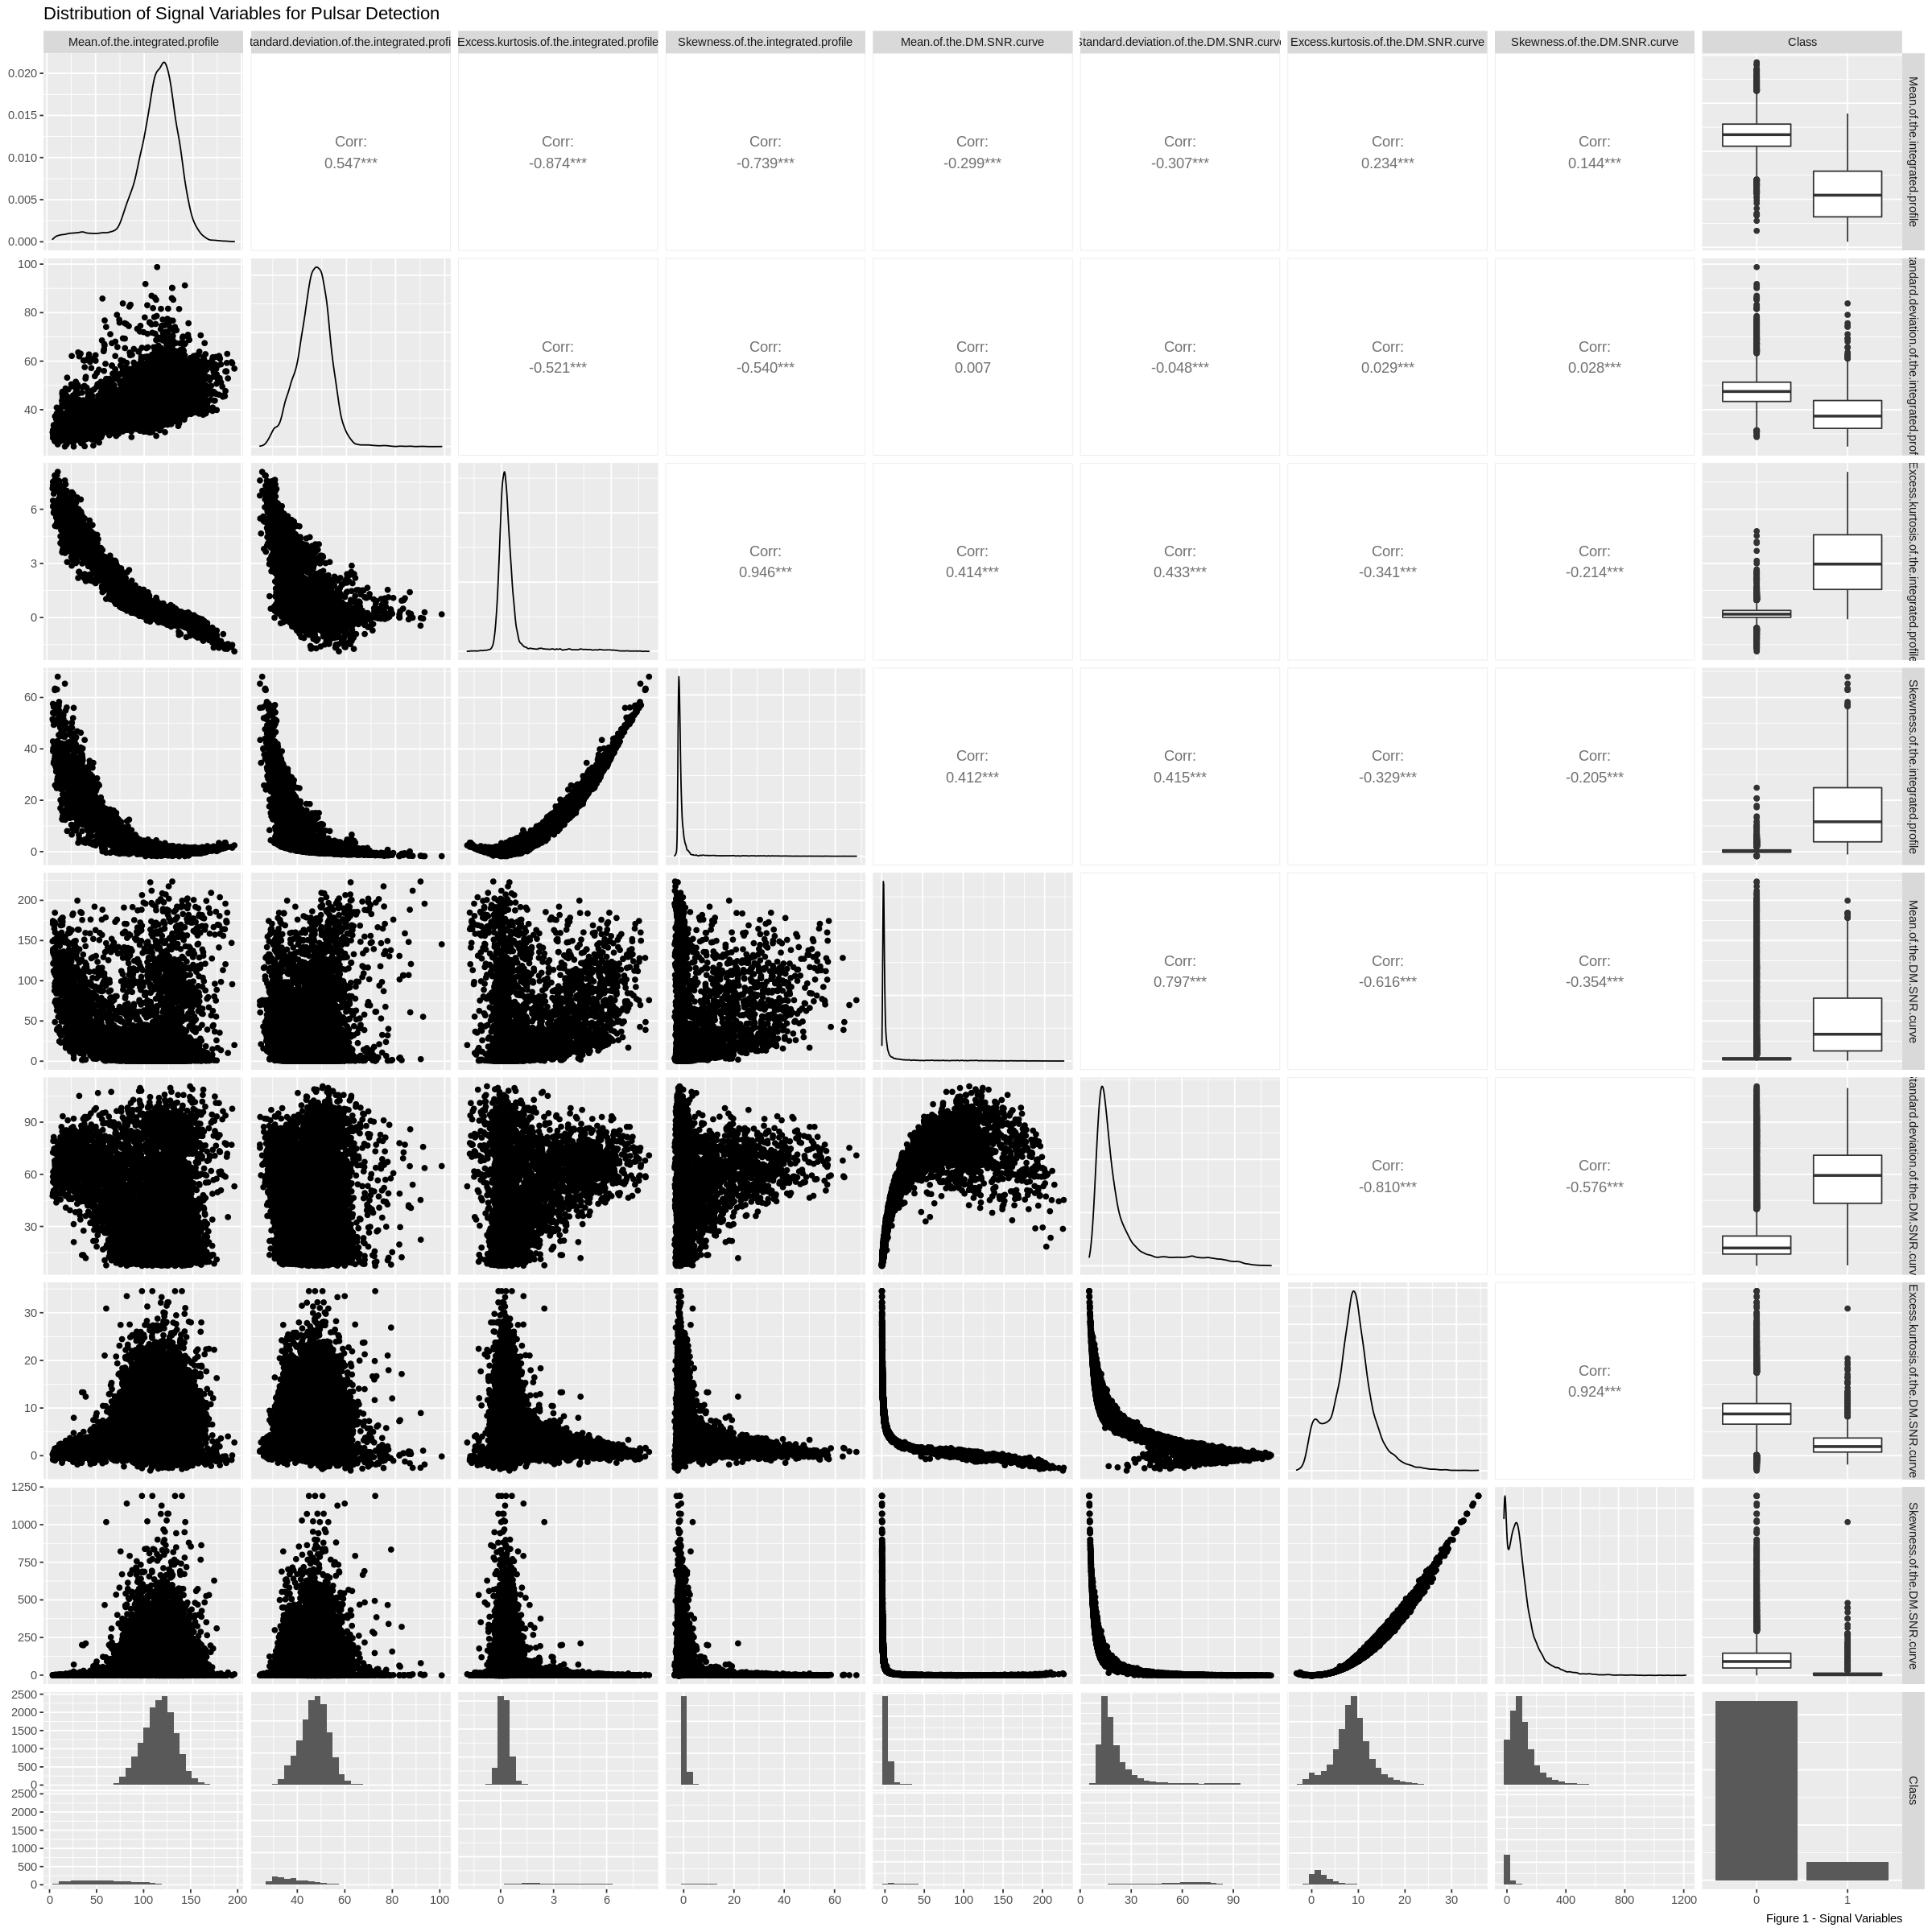

In [3]:
options(repr.plot.width = 20, repr.plot.height = 20)

pulsar_matrix <-ggpairs(pulsar_data) +
                ggtitle("Distribution of Signal Variables for Pulsar Detection") +
                labs(caption = "Figure 1 - Signal Variables") 
    
pulsar_matrix

We will now begin cleaning and wrangling our data to make it easier to summarize by selecting for variables we are interested for and dropping any rows that have missing values in the data frame.  

In [4]:
pulsar_data  <- pulsar_data |>
            select(Mean.of.the.integrated.profile, Excess.kurtosis.of.the.integrated.profile, Excess.kurtosis.of.the.DM.SNR.curve, Standard.deviation.of.the.DM.SNR.curve, Class) |>
            drop_na()

pulsar_data

Mean.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Excess.kurtosis.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,-0.234571412,7.975532,19.110426,0
102.50781,0.465318154,10.576487,14.860146,0
103.01562,0.323328365,7.735822,21.744669,0
136.75000,-0.068414638,6.896499,20.959280,0
88.72656,0.600866079,14.269573,11.468720,0
93.57031,0.531904850,10.621748,14.545074,0
119.48438,0.031460220,19.206230,9.279612,0
130.38281,-0.158322759,13.539456,14.378941,0
107.25000,0.452688025,9.001004,14.486853,0


Let's first see how many observations we have of each class. 

In [5]:
pulsar_data |>
  group_by(Class) |>
  summarize(n = n())

Class,n
<fct>,<int>
0,16259
1,1639


We can see that we have more non-pulsars (0) than pulsars (1). So we should give pulsars (1) more voting power in K-NN using the step_upsample function applied to our training data that we will create.

Since we are building a classifier, we must split our data into training and testing data. The training data will be used to build our classifier and the testing data will be used once we have built the classifier in order to test it. We will also check how many observations are in each class for our training data after upsampling. Recall that "0" means non-pulsar whereas "1" means it is a pulsar. 

In [6]:
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = Class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

ups_recipe <- recipe(Class ~., data = pulsar_train) |>
  step_upsample(Class, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

pulsar_train <- bake(ups_recipe, pulsar_train)

pulsar_ups_summary <- pulsar_train  |>
    group_by(Class) |>
    summarise(count = n())

pulsar_ups_summary



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Training information 

Training data contained 13423 data points and no incomplete rows.



── Operations 

• Up-sampling based on: Class | Trained



Class,count
<fct>,<int>
0,12200
1,12200


Now let us compare the distribution of our variables in the training data through a scatterplot. 

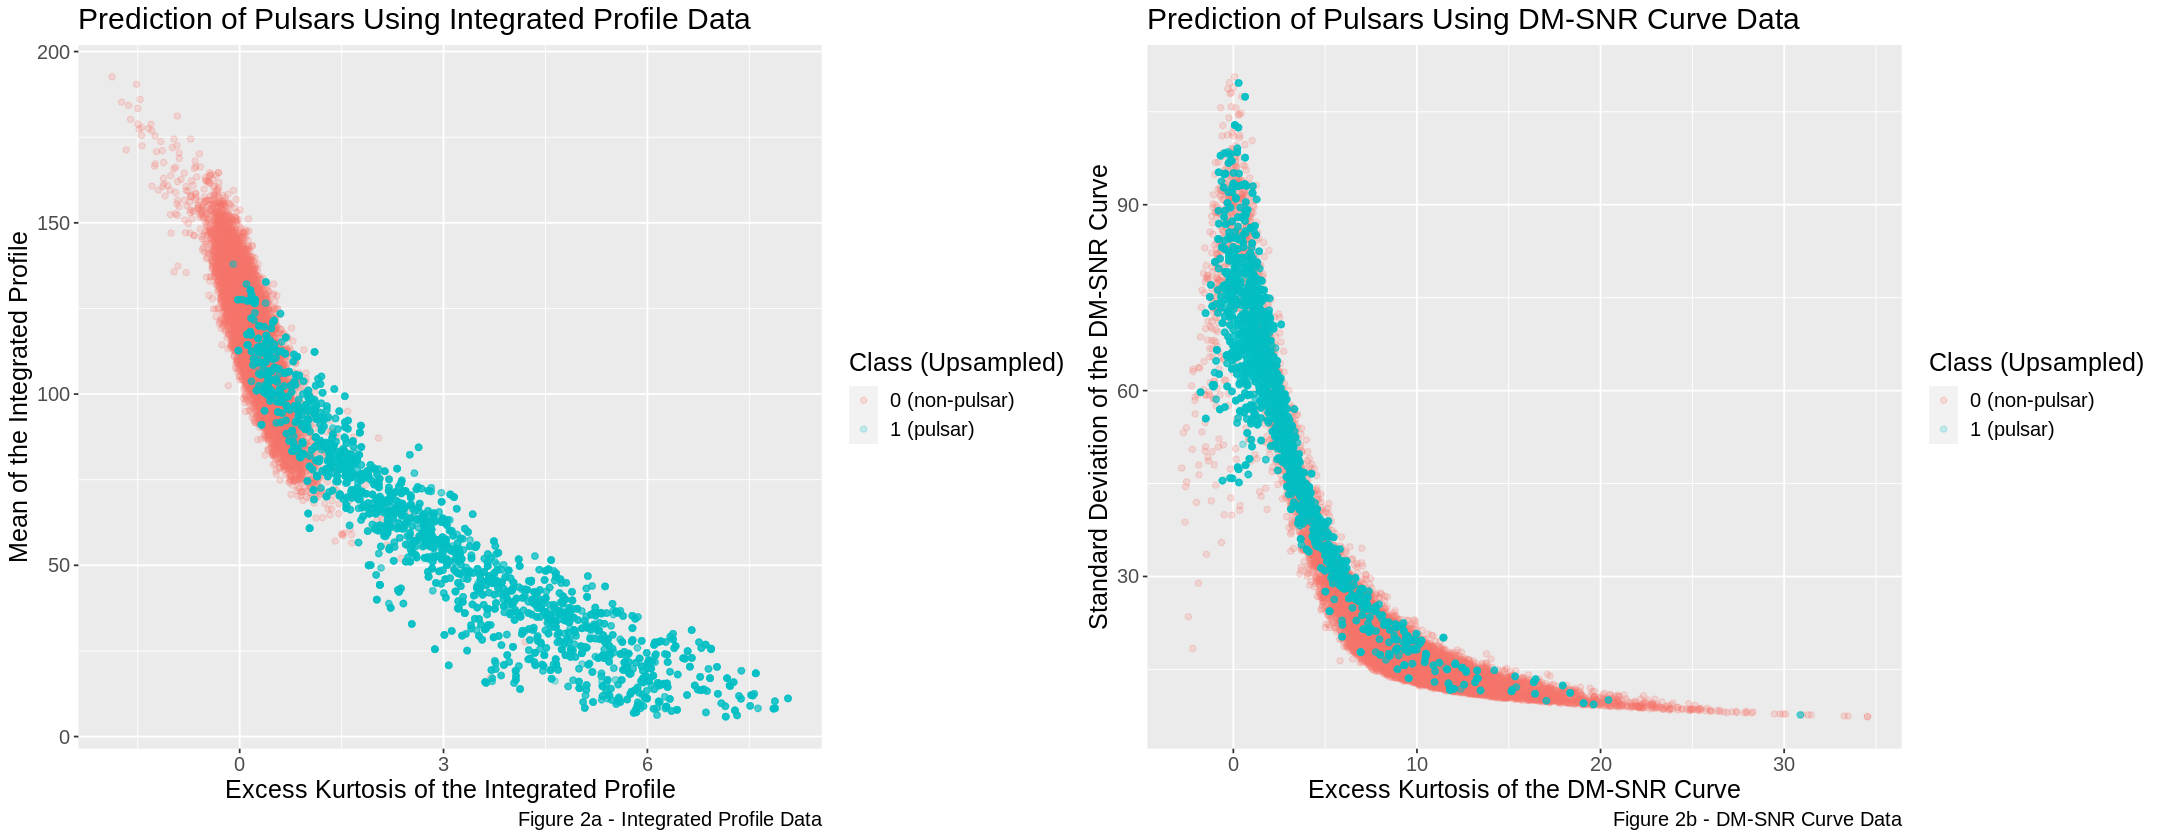

In [7]:
options(repr.plot.width = 18, repr.plot.height = 7)

integrated_plot <- pulsar_train |>
            ggplot(aes(x = Excess.kurtosis.of.the.integrated.profile, y= Mean.of.the.integrated.profile, color = Class)) +
            geom_point(alpha = 0.2) +
            xlab("Excess Kurtosis of the Integrated Profile") + 
            ylab("Mean of the Integrated Profile") +
            scale_color_discrete(labels = c("0 (non-pulsar)", "1 (pulsar)")) +
            ggtitle("Prediction of Pulsars Using Integrated Profile Data") + 
            labs(caption = "Figure 2a - Integrated Profile Data", color = "Class (Upsampled)") +
            theme(text = element_text(size = 15))

curve_plot <- pulsar_train |>
            ggplot(aes(x = Excess.kurtosis.of.the.DM.SNR.curve, y= Standard.deviation.of.the.DM.SNR.curve, color = Class)) +
            geom_point(alpha = 0.2) +
            xlab("Excess Kurtosis of the DM-SNR Curve") + 
            ylab("Standard Deviation of the DM-SNR Curve") +
            scale_color_discrete(labels = c("0 (non-pulsar)", "1 (pulsar)")) +
            ggtitle("Prediction of Pulsars Using DM-SNR Curve Data") +
            labs(caption = "Figure 2b - DM-SNR Curve Data", color = "Class (Upsampled)") +
            theme(text = element_text(size = 15))


plot_grid(integrated_plot, curve_plot, nrow = 1)    

Since K-NN is sensitive to the scale of predictors, we should also do some preprocessing to standardize the data. We are going to create a recipe that selects the four variables we want to use as predictors in order for us to then scale and center the data from these variables. 

In [8]:
pulsar_recipe <- recipe(Class ~.,data = pulsar_train) |> 
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

pulsar_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



Next, we will actually create and specify the K-NN model. However, it could be really hard to find the optimal value of K that comes up with the most precise classifications, so we have to tune our model using the training data to find the best K. 

In [9]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Then, to experiment with some possible K's to pick the best one, we will make use of 5-fold cross-validation. The idea of 5-fold cross-validation is we split the overall training data into 5 evenly-sized chunks or folds, and then iteratively use 1 chunk as the validation set and the remaining chunks as training sets. We train our model on the training sets and test on the validation set and whichever K value yields the highest cross-validation accuracy is the one we use. This method allows us to get a sense of how our model works without touching the actual test data. 

In [10]:
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = Class)

Finally, we create a workflow that combines the model specification, recipe, and cross-validation together. We then execute the workflow and collect the performance metric of each model with a specific parameter. Recall that we are tuning the model with different K values, so we also have to specify how many K's we would like to experiment with. Since our data has over 10 000 observations, we will use values up to K = 100 in our tuning by values of 5. 

In [11]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

pulsar_result <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
    collect_metrics()

pulsar_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9897131,5,0.0005513780,Preprocessor1_Model01
1,roc_auc,binary,0.9897131,5,0.0005513780,Preprocessor1_Model01
6,accuracy,binary,0.9743852,5,0.0009763221,Preprocessor1_Model02
6,roc_auc,binary,0.9901845,5,0.0004498804,Preprocessor1_Model02
11,accuracy,binary,0.9547541,5,0.0017039030,Preprocessor1_Model03
11,roc_auc,binary,0.9909315,5,0.0002636107,Preprocessor1_Model03
16,accuracy,binary,0.9482377,5,0.0015841105,Preprocessor1_Model04
16,roc_auc,binary,0.9907573,5,0.0004347968,Preprocessor1_Model04
21,accuracy,binary,0.9456557,5,0.0014611101,Preprocessor1_Model05


Now let's decide which K values to take a closer look at by plotting their accuracies in a line graph.

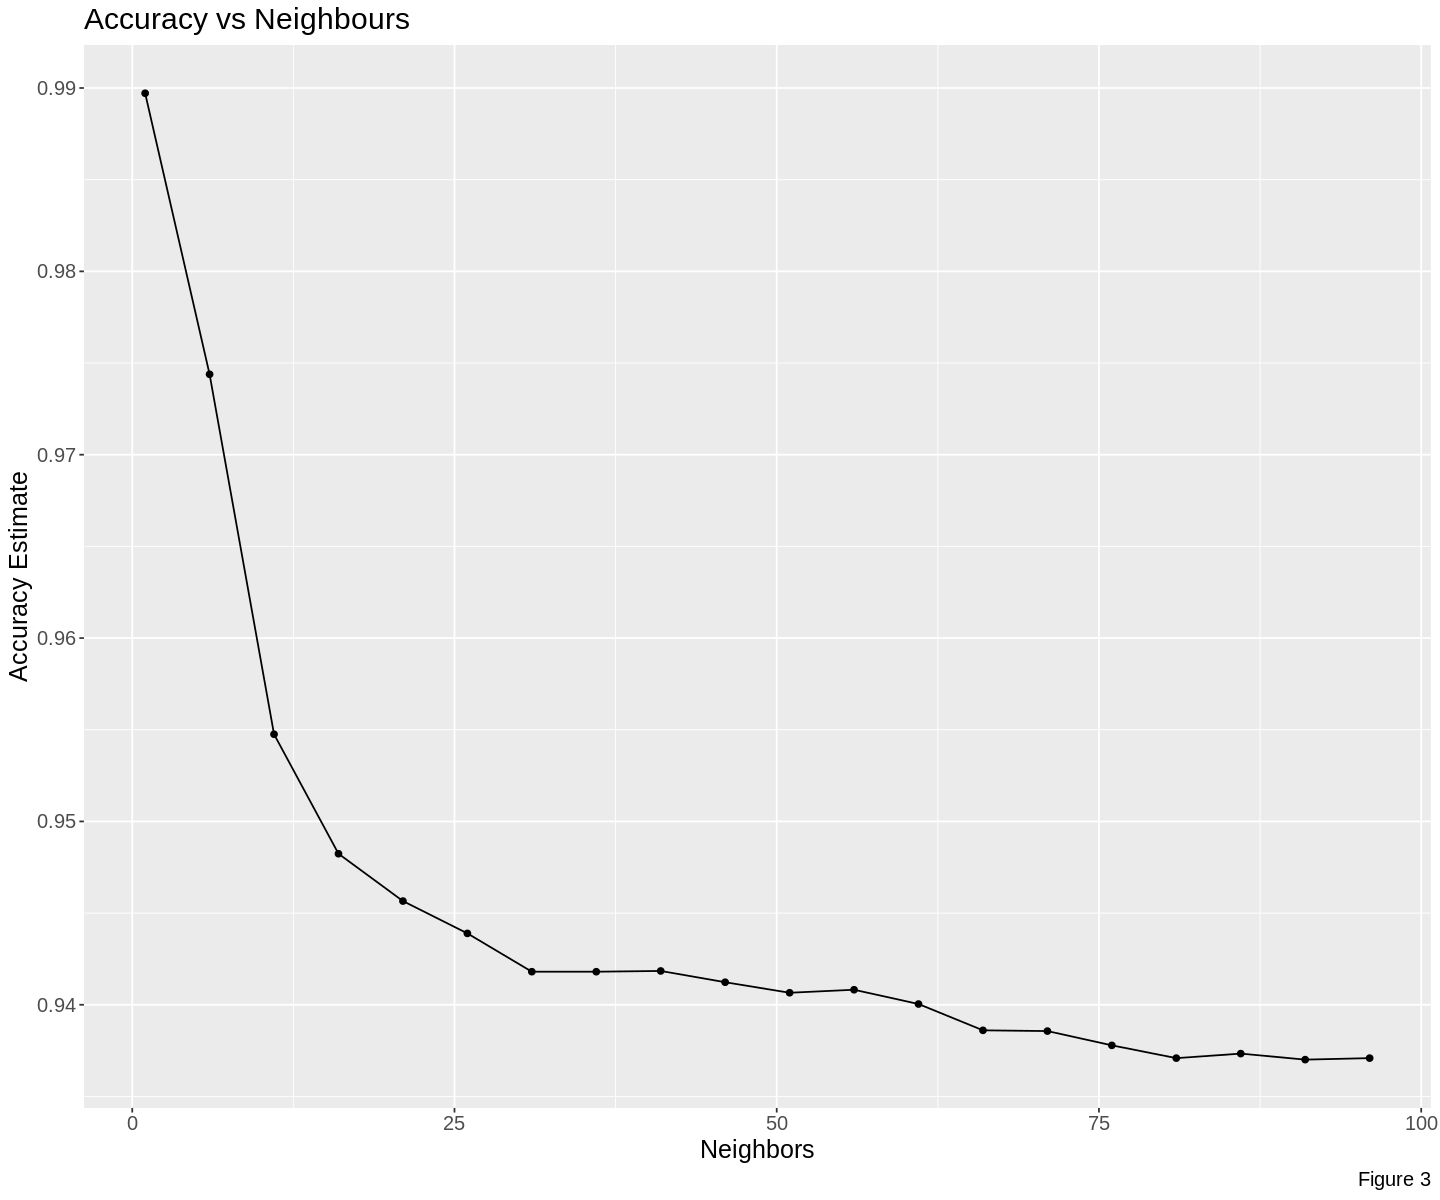

In [12]:
options(repr.plot.width = 12, repr.plot.height = 10)

accuracies <- pulsar_result |> 
       filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs Neighbours", caption = "Figure 3") + 
  theme(text = element_text(size = 15)) 

accuracy_vs_k

As the overall accuracy of our cross-validation has a downwards trend past K = 5, we will only take a closer look at the first 20 values of K.

In [13]:
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

pulsar_result <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
    collect_metrics()

pulsar_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9897131,5,0.0005513780,Preprocessor1_Model01
1,roc_auc,binary,0.9897131,5,0.0005513780,Preprocessor1_Model01
2,accuracy,binary,0.9897131,5,0.0005513780,Preprocessor1_Model02
2,roc_auc,binary,0.9897883,5,0.0005296765,Preprocessor1_Model02
3,accuracy,binary,0.9812295,5,0.0005671456,Preprocessor1_Model03
3,roc_auc,binary,0.9897998,5,0.0004921731,Preprocessor1_Model03
4,accuracy,binary,0.9812295,5,0.0005671456,Preprocessor1_Model04
4,roc_auc,binary,0.9897988,5,0.0004814744,Preprocessor1_Model04
5,accuracy,binary,0.9743852,5,0.0009763221,Preprocessor1_Model05


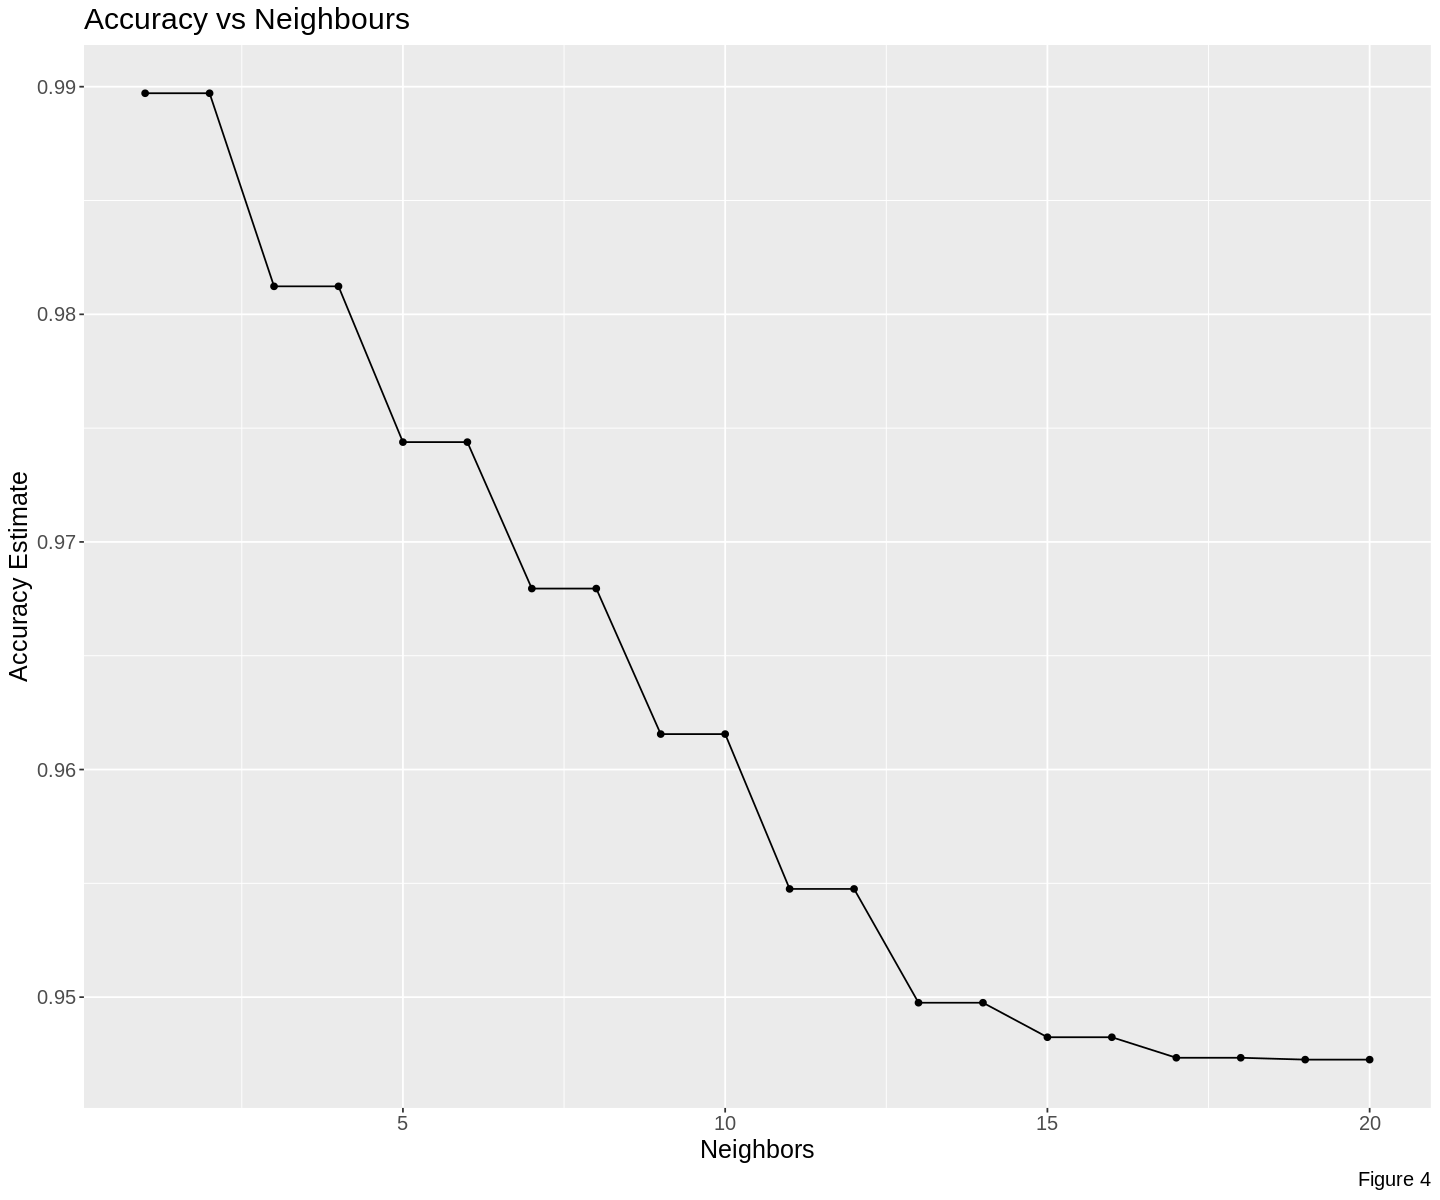

In [14]:
options(repr.plot.width = 12, repr.plot.height = 10)

accuracies <- pulsar_result |> 
       filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs Neighbours", caption = "Figure 4") + 
  theme(text = element_text(size = 15)) 

accuracy_vs_k

In the graph, we can clearly see that the accuracy is amongst the highest when K = 1 or 2, but we will choose K = 1 since it is better to have an odd K to avoid ties. 

Now let us use K = 1 to create the K-NN model and to execute the workflow. 

In [15]:
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
              set_engine("kknn") |>
              set_mode("classification")

best_fit <- workflow() |>
             add_recipe(pulsar_recipe) |>
             add_model(best_spec) |>
             fit(data = pulsar_train)

Then, let us use our final model and examine the accuracy of it by predicting on the test data and reporting the accuracy of the model as well, with the aid of a confusion matrix. 

In [16]:
pulsar_predictions <- predict(best_fit, pulsar_test) |>
                        bind_cols(pulsar_test)

pulsar_metrics <- pulsar_predictions |> 
                  metrics(truth = Class, estimate = .pred_class) |>
                  filter(.metric == "accuracy")

pulsar_conf_mat <- pulsar_predictions |>
                        conf_mat(truth = Class, estimate = .pred_class) 
pulsar_metrics
pulsar_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9680447


          Truth
Prediction    0    1
         0 3983   67
         1   76  349

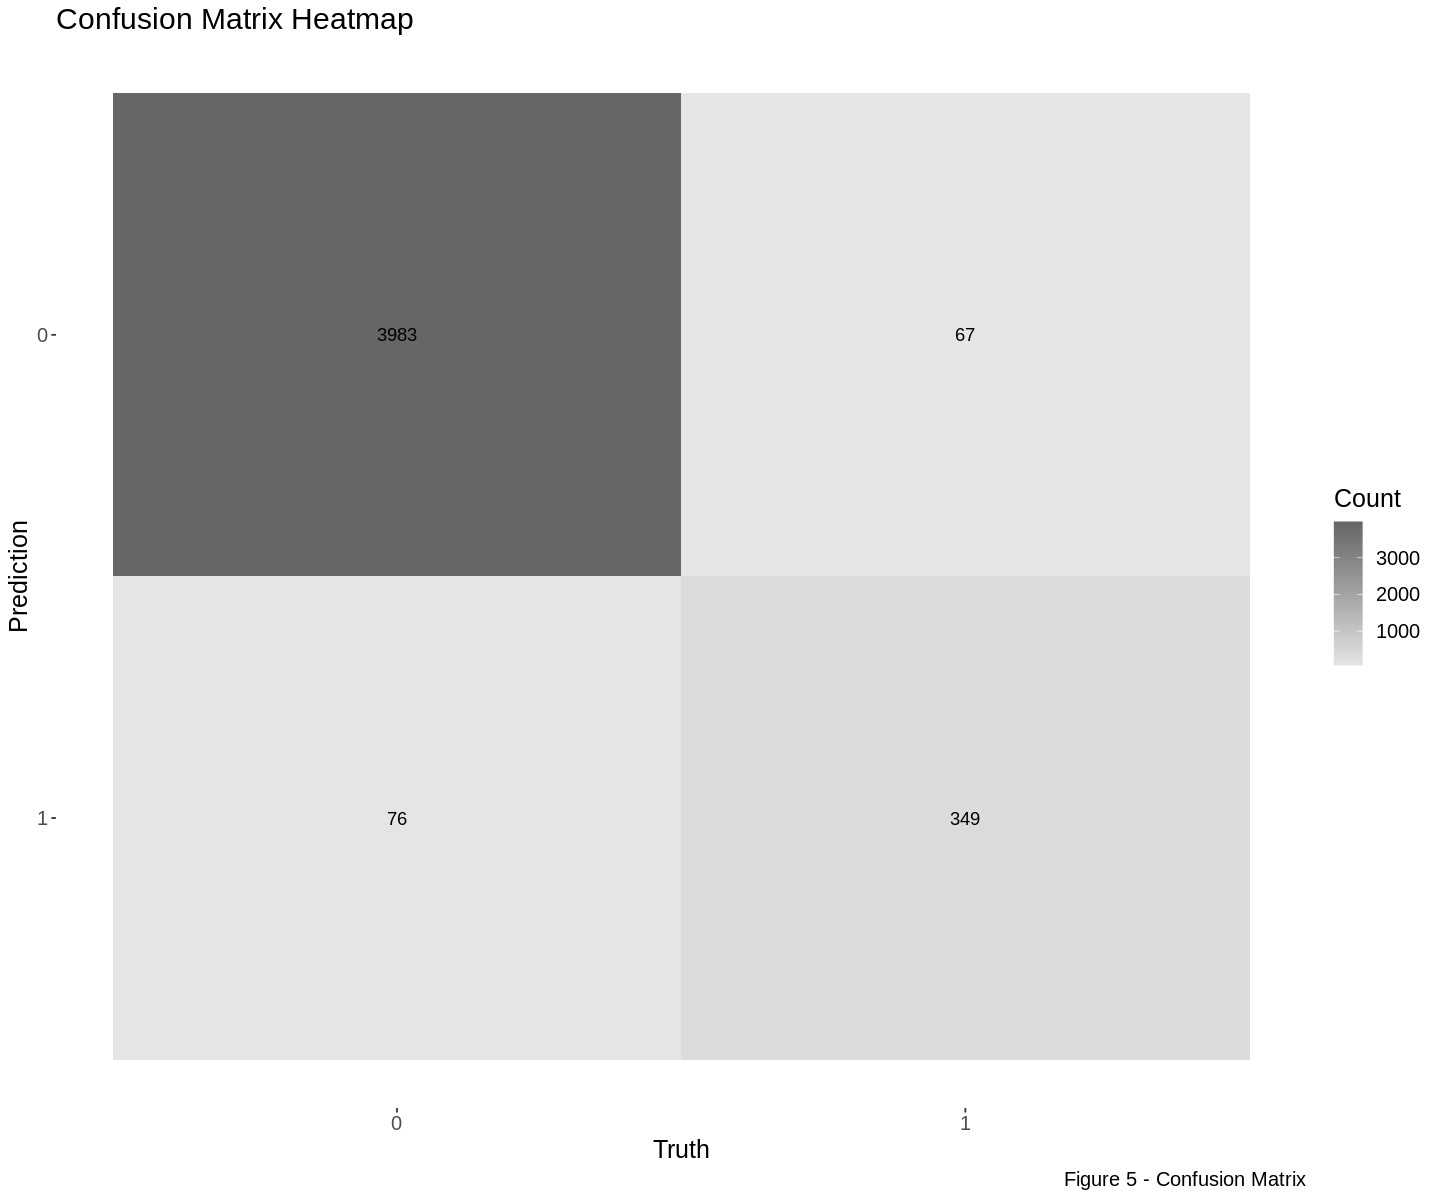

In [17]:
matrix_visual <- autoplot(pulsar_conf_mat, type = "heatmap") +
        theme(legend.position = "right") +
        labs(fill="Count") +
        ggtitle("Confusion Matrix Heatmap") +
        labs(caption = "Figure 5 - Confusion Matrix") +
        theme(text = element_text(size = 15))

matrix_visual

## 3) Discussion

When we look at the metrics computed above, we can see that we have an accuracy of 0.97 or 97%, which means that our classifier did a good job for the most part at detecting whether a set of signals came from a pulsar(1) or non-pulsar (0). Through the summary of observations earlier and through the confusion matrix, we can also see that the majority of predictions are 0 (non-pulsars). This is what we expected to find, as pulsar stars are a type of neutron star which are quite rare in general [8]. 

Pulsar stars can be valuable tools to help predict other space and physics phenomena since it is widely known that they are very dense and emit a lot of radiation. By building a classifier that helps identify pulsar stars faster, it may help speed up scientific research and discovery within astronomy. For example, pulsar stars can carry information about other things like space-time and gravitational waves caused by motions of things like blackholes[9]. By understanding pulsars, we may be able to answer to what extent can pulsars be predictive and provide information of other space and astrophysics phenomena. 

Furthermore, by identifying pulsars, we can find where pulsar stars are located. This can help us find pulsar planets and their frequency. Pulsar planets are rare and they rotate around pulsars [10].  One future question that may arise is; "to what extent do the pulsars we identify help us verify our current theories of physics and the universe?". This is important to note as pulsars are already being used to look at Einstein's Theory of General Relativity for example [11].  

## 4) References (IEEE Format)

[1] R. Lea, “What are pulsars?,” Space.com, 22-Apr-2016. [Online]. Available: https://www.space.com/32661-pulsars.html.

[2] R. Mandow, “Science talk - what are pulsar planets?,” Spaceaustralia, 05-Aug-2022. [Online]. Available: https://spaceaustralia.com/news/science-talk-what-are-pulsar-planets. 

[3] D. R. Lorimer and M. Kramer, 'Handbook of Pulsar Astronomy', Cambridge University Press, 2005.

[4] R. J. Lyon, 'Why Are Pulsars Hard To Find?', PhD Thesis, University of Manchester, 2016.

[5] 1.3.5.11. Measures of Skewness and Kurtosis,” national institutes of standards and technology. [Online]. Available: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm#:~:text=Kurtosis%20is%20a%20measure%20of,tails%2C%20or%20lack%20of%20outliers. 

[6] “Pulsar dispersion measure: Cosmos,” Pulsar Dispersion Measure | COSMOS. [Online]. Available: https://astronomy.swin.edu.au/cosmos/p/pulsar+dispersion+measure. 

[7] W. Gragido, J. Pirc, N. Selby, and D. Molina, “Signal-to-noise ratio,” Blackhatonomics, pp. 45–55, 2013.

[8] “Black holes and Neutron Stars,” University of Maryland: Department of Astronomy. [Online]. Available: https://www.astro.umd.edu/~miller/poster1.html#:~:text=Neutron%20stars%20are%20born%20during,least%2040%20light%20years%20away.

[9] N. Nm, “Pulsars: The Universe's gift to physics,” Astronomy.com, 20-Feb-2012. [Online]. Available: https://astronomy.com/news/2012/02/pulsars---the-universes-gift-to-physics. 

[10] B. Berman, “Weird object: Pulsar planets,” Astronomy.com, 23-Oct-2015. [Online]. Available: https://astronomy.com/magazine/weirdest-objects/2015/10/10-pulsar-planets. 

[11] “Black holes and Neutron Stars,” University of Maryland: Department of Astronomy. [Online]. Available: https://www.astro.umd.edu/~miller/poster1.html#:~:text=Neutron%20stars%20are%20born%20during,least%2040%20light%20years%20away. 